# <font color=black> Analysis - FC-based parcellation using correlation </font>
<hr style="border:1px solid black">

In [2]:
import sys,json
import glob, os
import numpy as np
import nibabel as nib
import time

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Initialization `SENSORY`
<hr style="border:0.5px solid black">

### Load configuration file 

In [2]:
# Load the config file with all information
with open('../../config/config_fc_based_parcellation_NK.json') as config_file:
    config = json.load(config_file)

### Set relevant parameters

In [16]:
# Define tag of this analysis (used for saving)
config['output_tag'] = "dorsal_to_postcentral_sensory"
# Define source, target, and the corresponding masks
source = 'spinalcord'
target = 'brain'
# Note: paths should be with respect to main directory
config['masks']['brain'] = "/templates/MNI_hc_project/julich_postcentral_sensory.nii.gz"
config['masks']['spinalcord'] = "/templates/PAM50_hc_project/template/PAM50_cord_C1toC8_D.nii.gz"
config['list_subjects'] = ["P030","P099","A006"]
#config['list_subjects'] = ["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046"]

### Instantiate class
_Note: this will save a config file with all relevant information and prepare folder structure_

In [17]:
fc_parcellation = FC_Parcellation(config,source,target,'corr')

# Analyses
<hr style="border:0.5px solid black">

### Compute the voxelwise correlation & run clustering for each subject independently

In [ ]:
start = time.time()
# Loop through the subjects to compute fc and clustering 
for sub_id,sub in enumerate(fc_parcellation.config['list_subjects']): 
    print(f'\033[1mSUBJECT {sub}\033[0m')
    # Compute correlation without saving files
    dict_corr = fc_parcellation.compute_voxelwise_fc(sub=sub, 
                                                  load_from_file=True, 
                                                  save_results=True)
    # Run clustering and save labels
    fc_parcellation.run_clustering(dict_corr,
                                    k_range=range(5,10),algorithm='kmeans',
                                    overwrite=True,
                                    save_results=True)
print("\033[1m... Operation performed in %.2f s!\033[0m" % (time.time() - start))

SUBJECT P030
COMPUTE VOXELWISE FC
Standardize = True
Loading from file = True
Saving results = True
... Load FC from file

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = kmeans
K value(s) = range(5, 10)
Overwrite results = True
Saving results = True

K = 5
... Running k-means clustering


### Compute the group-level clustering and generate corresponding maps

In [10]:
fc_parcellation.group_clustering(k_range=range(5,10),overwrite=True)

CLUSTERING AT THE GROUP LEVEL
K value(s) = range(5, 10)
Overwrite results = True
Saving results = True


K = 5
... Computing hierarchical clustering and relabeling
K = 6
... Computing hierarchical clustering and relabeling
K = 7
... Computing hierarchical clustering and relabeling
K = 8
... Computing hierarchical clustering and relabeling
K = 9
... Computing hierarchical clustering and relabeling

DONE


In [11]:
fc_parcellation.prepare_target_maps(label_type='indiv',k_range=5,overwrite=True, save_results=True)

PREPARE TARGET MAPS
Type of source labels = indiv
K value(s) = 5
Overwrite results = True
Saving results = True

K = 5
... Computing target maps
...... Subject P030
...... Subject P099
...... Subject A006
...... Subject A007
DONE



In [1]:
import pandas as pd

In [77]:
internal_df = pd.read_pickle('/media/miplab-nas2/Data3/BMPD/hc_project/brain&spine/results/fc_parcellation/corr/dorsal_to_postcentral_sensory/source/dorsal_to_postcentral_sensory_kmeans_internal_validity.pkl')

<Figure size 432x288 with 0 Axes>

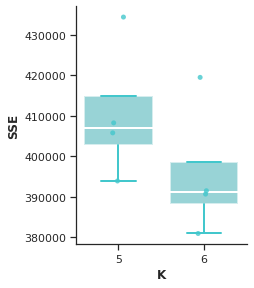

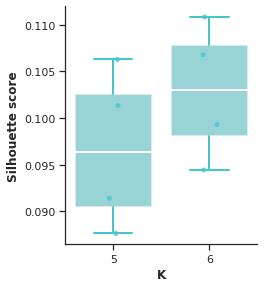

In [85]:
import seaborn as sns
from matplotlib import pyplot as plt

metrics=['SSE','silhouette']
metrics_names = ['SSE', 'Silhouette score']
color="#43c7cc"
sns.set(style="ticks",  font='sans-serif');
k_range = [5,6]
filtered_df = internal_df[internal_df['k'].isin(k_range)]

for metric_ind, metric in enumerate(metrics):
    plt.figure(metric_ind)
    g = sns.catplot(y=metric,x="k",data=filtered_df, kind="box", legend=True, legend_out=True,
                 linewidth=2,medianprops=dict(color="white"),color=color, 
                 boxprops=dict(alpha=.6,edgecolor=None),whiskerprops=dict(color=color), capprops=dict(color=color), fliersize=0, aspect=0.5);
    #g.set(ylim=(0, 0.6))
    g.fig.set_size_inches(5,4)
    sns.stripplot(y=metric,x="k",data=filtered_df,
                 size=5, color=color, alpha=.8, linewidth=0,edgecolor='white',dodge=True);
    
    g.set_axis_labels("K", metrics_names[metric_ind],fontsize=12, fontweight='bold')
    #g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_subsampling_stability_' + dataset + '_' + method+ '_' +  nsub + 'sub.pdf', format='pdf')

In [3]:
group_df = pd.read_pickle('/media/miplab-nas2/Data3/BMPD/hc_project/brain&spine/results/fc_parcellation/corr/dorsal_to_postcentral_sensory/source/dorsal_to_postcentral_sensory_kmeans_group_validity.pkl')

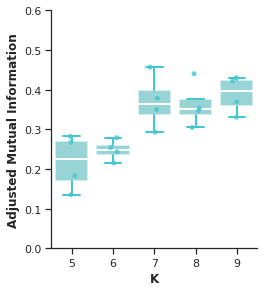

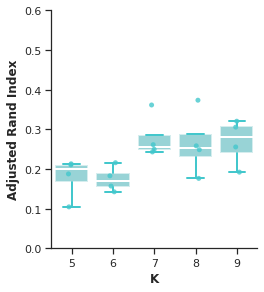

In [86]:
import seaborn as sns
from matplotlib import pyplot as plt

metrics=['ami','ari']
metrics_names = ['Adjusted Mutual Information', 'Adjusted Rand Index']
color="#43c7cc"
sns.set(style="ticks",  font='sans-serif');

for metric_ind, metric in enumerate(metrics):
    g = sns.catplot(y=metric,x="k",data=group_df, kind="box", legend=True, legend_out=True,
                 linewidth=2,medianprops=dict(color="white"),color=color, 
                 boxprops=dict(alpha=.6,edgecolor=None),whiskerprops=dict(color=color), capprops=dict(color=color), fliersize=0, aspect=0.5);
    g.set(ylim=(0, 0.6))
    g.fig.set_size_inches(5,4)
    sns.stripplot(y=metric,x="k",data=group_df,
                 size=5, color=color, alpha=.8, linewidth=0,edgecolor='white',dodge=True);
    
    g.set_axis_labels("K", metrics_names[metric_ind],fontsize=12, fontweight='bold')
    #g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_subsampling_stability_' + dataset + '_' + method+ '_' +  nsub + 'sub.pdf', format='pdf')

In [68]:
corr_df = pd.read_pickle('/media/miplab-nas2/Data3/BMPD/hc_project/brain&spine/results/fc_parcellation/corr/dorsal_to_postcentral_sensory/source/dorsal_to_postcentral_sensory_kmeans_cophenetic_correlation.pkl')

Text(0, 0.5, 'Cophenetic correlation')

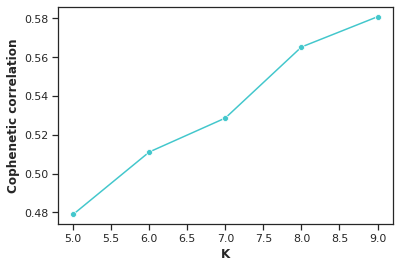

In [75]:
sns.lineplot(data=corr_df, x='k', y='corr', marker='o',color=color)
plt.xlabel('K', fontsize=12, fontweight='bold')
plt.ylabel('Cophenetic correlation', fontsize=12, fontweight='bold')



# BELOW: archives

# Initialization `SENSORY`
<hr style="border:0.5px solid black">

### Load configuration file 

In [ ]:
# Load the config file with all information
with open('../../config/config_fc_based_parcellation_NK.json') as config_file:
    config = json.load(config_file)

### Set relevant parameters

In [ ]:
# Define tag of this analysis (used for saving)
config['output_tag'] = "dorsal_to_postcentral_sensory"
# Define source, target, and the corresponding mask
source = 'spinalcord'
target = 'brain'
# Note: paths should be with respect to main directory
config['masks']['brain'] = "/templates/MNI_hc_project/julich_postcentral_sensory.nii.gz"
config['masks']['spinalcord'] = "/templates/PAM50_hc_project/template/PAM50_cord_C1toC8_D.nii.gz"
config['list_subjects'] = ["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043"]

### Instantiate class
_Note: this will save a config file with all relevant information and prepare folder structure_

In [ ]:
fc_parcellation = FC_Parcellation(config,source,target,'corr')

# Analyses
<hr style="border:0.5px solid black">

### Compute the voxelwise correlation & run clustering for each subject independently

In [ ]:
start = time.time()
# Initialize empty array for individual labels
mask_source_path = config['main_dir']+config['masks'][source]
nvox_source = np.count_nonzero(nib.load(mask_source_path).get_fdata().astype(bool))
subject_labels = np.zeros((len(fc_parcellation.config['list_subjects']),nvox_source))
for sub_id,sub in enumerate(fc_parcellation.config['list_subjects']): 
    print(f'SUBJECT {sub}')
    # Compute correlation without saving files
    dict_corr = fc_parcellation.compute_voxelwise_fc(sub=sub, 
                                                  load_from_file=True, 
                                                  save_results=True, 
                                                  mask_source_path=mask_source_path, 
                                                  mask_target_path=config['main_dir']+config['masks'][target])
    # Run clustering and save labels
    subject_labels[sub_id,:] = fc_parcellation.run_clustering(dict_corr,
                                                              k=8,algorithm='kmeans',
                                                              load_from_file=True,
                                                              save_results=True)
print("... Operation performed in %.2f s!" % (time.time() - start))

### Compute the group-level clustering and generate corresponding maps

In [ ]:
group_labels, indiv_labels_relabeled = fc_parcellation.group_clustering(subject_labels)
fc_parcellation.prepare_seed_map(group_labels)
# Rechange to True later
fc_parcellation.prepare_target_maps(indiv_labels_relabeled, load_from_file=False, save_results=True)